#### Quick start guide.
- Little ditty for comparing flow laws

- Text written after hashtags (#) indicate comments or instructions.

    - Block 1. loads required python packages.
    - Block 2. loads the flow law file and prints in to the screen.
    - Block 3. Demonstrates how to identify and print specific flow laws
    - Block 4. creates the function to compare dislocation & dissolution flow laws in grain size shear stress state,
    - Block 5. Creates the function to compare different flow laws in shear stress strain rate space.

- To do: add Byerlees law in shear stress Depth/temperature space
    
- We are using the full equation for dislocation and dissolution creep (eq. 1):
    
$ \epsilon_{dot}=A \sigma^n d^{-m} f_{H2O}^r exp(\frac{-(Q+pV)}{RT}) exp(\alpha \phi)$<br>
<br>
<br>
    **ϵ_dot** is strain rate (s^-1)<br>
    **A** is the experimentally determined prefactor ()<br>
    **σ** is the shear stress (in MPa)<br>
    **n** in the experimentally determined exponent<br>
    **d** and **m** are grain size (in μm) and the grainsize exponent<br>
    **f_h2o** and **r** are the water fugacity (in MPa) and the fugacity exponent<br>
    **Q** is the activation energy(J/mol)<br>
    **p** and **V** are the pressure and volume . . .<br>
    **R** is the gas constant<br>
    **T** is temperature in Kelvin<br>
    **α** is the melt function constant<br>
    **ϕ** is the melt fraction<br>
    
- We have a few Low Temperature Plasticity flow laws as well, that have a different form (eq. 2):
    
$ \epsilon_{dot}=A (\frac{\sigma}{\mu})^2 exp(\frac{-Q}{RT}(1-(\frac{\sigma}{\tau_{o}})^p)^q)$<br>
<br>
<br>

    
- Thin film solution transfer equation:
    
$ \epsilon_{tf}=\frac{A_{R} V_{m} \rho_{f} c D w \sigma_{d}}{\rho_{s} R T d^3} $<br>
<br>
<br>
- Inverting the LTP flow law to represent shear stress as a function of strain rate requires an approximation.
- Using the formulation of Kameyama et al. (1999) after Billen (2020) we approximate with (eq. 3.1):

$ \sigma = \frac{\gamma \sigma_{p}}{(A(\gamma \sigma_{p})^{n})^{\frac{1}{s+n}}} exp[\frac{E_{p}}{RT}\frac{(1-\gamma^{p})^{q}}{(s+n)}] \epsilon^{\frac{1}{s+n}}$

- where (eq. 3.2):<br>
    <br>
$\gamma = \frac{\sigma_{ref}}{\sigma_{p}}$<br>
<br>
- and (eq. 3.3):<br>
    <br>
$s = (\frac{E_{p}}{RT})pq(1-\gamma^{p})^{q-1}\gamma^{p}$<br>
<br>
- Finally, if we want: there is a viscosity flag that uses a simple viscosity formulation (eq. 4):<br>
    <br>
$ \eta = \frac{\sigma}{2\epsilon_{dot}}$


In [1]:
import math as m #math toolkit
import numpy as np #used for matrix manipulation
import matplotlib.pyplot as plt #plotting
import pandas as pd #spreadsheet, need xlr package
from scipy import optimize # for O Fugaity
from scipy import special # for array-wise error function (special.erf)

In [2]:
###DEFINE EMBEDDED FUNCTIONS###
#These are back end functions that are called within the main rheology functions
#progress through this block

##----------------------------------------H2O FUGACITY---------------------------------------------------------------------
    #This block calculates the fugacity of H2O, it should be implemented as a lookup table of fH2O values because it is rather computationally expensive
    #alternatively a simple approximation can be used as was done in the Kitter et al. (2016; J. Struc. Geol. 83, 194-206).
    #The code uses the Pitzer & Sterner (1994) formulation and was coded by Tony Withers, Downloaded from GitHub 1/2023 (https://github.com/forsterite/fugacity/)

coeff=[]
coeff.append([0,0,0.24657688e6,0.51359951e2,0,0])
coeff.append([0,0,0.58638965e0,-0.28646939e-2,0.31375577e-4,0])
coeff.append([0,0,-0.62783840e1,0.14791599e-1,0.35779579e-3,0.15432925e-7])
coeff.append([0,0,0,-0.42719875e0,-0.16325155e-4,0])
coeff.append([0,0,0.56654978e4,-0.16580167e2,0.76560762e-1,0])
coeff.append([0,0,0,0.10917883e0,0,0])
coeff.append([0.38878656e13,-0.13494878e9,0.30916564e6,0.75591105e1,0,0])
coeff.append([0,0,-0.65537898e5,0.18810675e3,0,0])
coeff.append([-0.14182435e14,0.18165390e9,-0.19769068e6,-0.23530318e2,0,0])
coeff.append([0,0,0.92093375e5,0.12246777e3,0,0])

def PSeos(volume, temperature, targetP):  # cc/mol, Kelvins, bars
    R=8314510  # Pa.cc/K/mol
    den=1/volume[0]  # mol/cc
    c=[]
    for i in range(10):
        c.insert(i,coeff[i][0]*temperature**-4+coeff[i][1]*temperature**-2
                    +coeff[i][2]*temperature**-1+coeff[i][3]
                    +coeff[i][4]*temperature+coeff[i][5]*temperature**2)
    pressure=(den+c[0]*den**2-den**2*((c[2]+2*c[3]*den+3*c[4]*den**2
                +4*c[5]*den**3)/(c[1]+c[2]*den+c[3]*den**2+c[4]*den**3
                +c[5]*den**4)**2)+c[6]*den**2*m.exp(-c[7]*den)
                +c[8]*den**2*m.exp(-c[9]*den))*R*temperature/1e5
    return pressure-targetP  # bars

def PSvolume(pressure, temperature):  # bars, Kelvins
    volume=optimize.root(PSeos, 10, args = (temperature, pressure))
    return volume.x

def PSfugacity(pressure, temperature, den_out=False):  # bars, Kelvins
    R=8314510  # Pa.cc/K/mol
    c=[]
    for i in range(10):
        c.insert(i,coeff[i][0]*temperature**-4+coeff[i][1]*temperature**-2
                    +coeff[i][2]*temperature**-1+coeff[i][3]
                    +coeff[i][4]*temperature+coeff[i][5]*temperature**2)
    volume=PSvolume(pressure, temperature)
    den=1/volume[0]  # mol/cc
    fug=m.exp(m.log(den)+c[0]*den+(1/(c[1]+c[2]*den+c[3]*den**2
                                            +c[4]*den**3+c[5]*den**4)-1/c[1])
                    -c[6]/c[7]*(m.exp(-c[7]*den)-1)
                    -c[8]/c[9]*(m.exp(-c[9]*den)-1)
                    +pressure*1e5/(den*R*temperature)
                    +m.log(R*temperature)-1)/1e5
    if den_out==False:
        return fug  # bars
    else:
        density = den * 1000 * 18.0153 #recast density from mol/cc to  kg/m3 H2O
        return fug, density
##-----------------------------------------------------------------------------------------------------------------##   
##
##
##
##--------------------LOW TEMPERATURE PLASTICITY FLOW LAW APPROXIMATION SOLVER------------------------------#
# function to invert LTP peierls mechanism equation to solve for differential stress as a function of strain rate instead of
def LTP_γ(ID, T, ϵ, γ_i=0.5, max_err=1e-16):
    
    n=flow_laws.n[ID]
    
    if LTP.loc[LTP['ID'] == ID]['mu'].values[0] > 1:
        μ=LTP.loc[LTP['ID'] == ID]['mu'].values[0]*1e9
        A=m.pow(10,flow_laws.logA[ID])/m.pow(μ,n)
    else:
        μ=1
        A=m.pow(10,flow_laws.logA[ID])/1e12
    
    τ=LTP.loc[LTP['ID'] == ID]['tau'].values[0]*1e9
    Q = flow_laws.Q[ID]*1000
    p = LTP.loc[LTP['ID'] == ID]['p'].values[0]
    q = LTP.loc[LTP['ID'] == ID]['q'].values[0]
    
    R=8.314
    T= T
    
        
    γ = γ_i
    σ_err = 100
    
    i=1
    while σ_err >= max_err:
        s = Q / (R*T) * p * q * m.pow((1-m.pow(γ, p)), (q-1)) * m.pow(γ, p)
        σ = γ * τ / m.pow(A*m.pow(γ*τ,n),1/(s+n)) * m.exp((Q/(R*T))*(m.pow(1-m.pow(γ,p),q)/(s+n)))*m.pow(ϵ,1/(s+n))
        ϵ_t = A * m.pow(σ,n) * m.exp(-Q/(R*T)*m.pow(1-m.pow(σ/τ,p),q))
        σ_t = γ * τ / m.pow(A*m.pow(γ*τ,n),1/(s+n)) * m.exp((Q/(R*T))*(m.pow(1-m.pow(γ,p),q)/(s+n)))*m.pow(ϵ_t,1/(s+n))
        σ_err=abs(1-σ_t/σ)
        i=i+1
        γ=σ_t/τ
        if i == 10:         #various print output to test approximation loops
            #print(ϵ_t)         #should very closely match input ϵ value
            #print(σ_t/1e6)     # shear stress value for chosen γ
            #print('best fit γ = ',γ)           # final γ value for approximation
            #print('σ error = ', σ_err)       # percent error between approx σ and calculated σ
            #print(i)           # number of interation required to minimize error
            break              # breaks out of loop if max_err is not reached in ten steps
    if i <=9:               #print out same as above IF loop minimizes before break point
        #print(ϵ_t)
        #print(σ_t/1e6)
        #print('best fit γ = ',γ)
        #print('σ error = ', σ_err)
        #print(i)
        i=i+0
    return σ/1e6

In [3]:
fugacity,density=PSfugacity(10000, 973, den_out=True)
print(fugacity/10)
print(density)
volume=1000/density*18.0153
print(volume)

T_Vols=np.linspace(0,2,100)
T=698

#Si solubility Fournier & Potter 1982
A_tf= -4.66206 + 0.0034063 * T + 2179.7 / T - 1.1292e6 * T ** -2 + 1.3543e8 * T **-3
B_tf= -0.0014180 * T - 806.97 / T
C_tf= 3.9465e-4 * T
solubilities = A_tf + B_tf*T_Vols + C_tf*T_Vols**2

#Si diffusivity

solubility = A_tf + B_tf*m.log10(volume) + C_tf*m.log10(volume)**2
#ϵ_tf = thin_film.A[dis_ID] * thin_film.V[dis_ID] * thin_film.rho_f[dis_ID] * thin_film.c[dis_ID] \
#* thin_film.D[dis_ID] * thin_film.w[dis_ID] * σ_plot \
#/ (thin_film.rho_s[dis_ID] * R * T * m.pow(d, thin_film.m[dis_ID]))

1444.5002175766442
918.6355002200069
19.610933820525617


(0.0, 2.0)

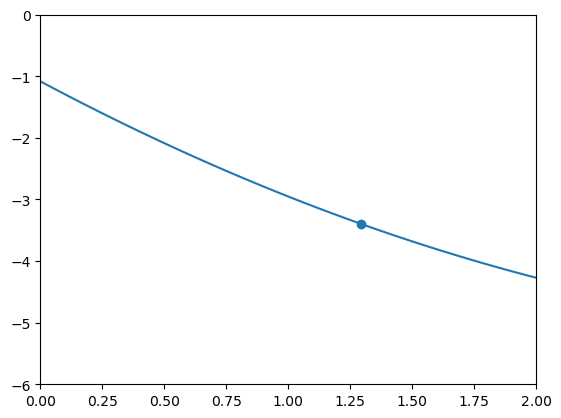

In [4]:
plt.plot(T_Vols, solubilities)
plt.scatter(m.log10(volume), solubility)
plt.ylim(-6,0)
plt.xlim(0,2)

In [5]:
print(10**solubility)

0.00040315944653631


In [6]:
flow_laws=pd.read_excel('flow_lawsv2.xls')
LTP=pd.read_excel('LTP.xlsx')
rows=flow_laws.shape[0]
flow_laws.head(rows)

,ID,Mineral,H2O,Min_Mode,Flow_Law,logA,n,Q,m,r,V,Reference
0,0,Albite,wet,100Ab,Disl_Creep,3.4000,3.0,332.0,0.0,0.0,0.0,Offerhaus et al 2001
1,1,Albite,NaN,100Ab,Disl_Creep,-5.6210,3.9,234.0,0.0,0.0,0.0,Shelton & Tullis 1981
2,2,Albite,wet,100Ab,Diff_Creep,3.9000,1.0,193.0,3.0,0.0,0.0,Offerhaus et al 2001
3,3,Anorthite,dry,100An,Disl_Creep,12.7000,3.0,648.0,0.0,0.0,0.0,Rybacki & Dresen 2000
4,4,Anorthite,dry,100An,Disl_Creep,12.7000,3.0,641.0,0.0,0.0,24.0,Rybacki et al 2006
...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,Plagioclase,NaN,70Pl(Ab50)_23Cpx,Disl_Creep,2.2800,4.7,485.0,0.0,0.0,0.0,Mackwell et al 1998
59,59,Eclogite,dry,50Gt_40Omp_10Qtz,Disl_Creep,3.3000,3.5,403.0,0.0,0.0,27.2,Zhang & Green 2007
60,60,Eclogite,NaN,50Gt_40Omp_10Qtz,Disl_Creep,3.3000,3.4,480.0,0.0,0.0,0.0,Jin et al 2001
61,61,Quartzite,wet,100Qtz,Disl_Creep,-11.7570,4.0,125.0,0.0,1.0,0.0,"Tokle et al., 2019"


In [7]:
##To identify all flow for a given mineral: flow_laws.loc[flow_laws['Mineral']=='Albite']
##Given reference: flow_laws.loc[flow_laws['Reference']=='Hirth et al 2001']
## Given n value: flow_laws.loc[flow_laws['n'] >= 3]
flow_laws.loc[flow_laws['Mineral']=='Albite']

,ID,Mineral,H2O,Min_Mode,Flow_Law,logA,n,Q,m,r,V,Reference
0,0,Albite,wet,100Ab,Disl_Creep,3.400,3.0,332.0,0.0,0.0,0.0,Offerhaus et al 2001
1,1,Albite,NaN,100Ab,Disl_Creep,-5.621,3.9,234.0,0.0,0.0,0.0,Shelton & Tullis 1981
2,2,Albite,wet,100Ab,Diff_Creep,3.900,1.0,193.0,3.0,0.0,0.0,Offerhaus et al 2001


In [8]:
##We can also explore rheologic evolution along the slabtop for a bunch of 
#different margins (van Keken et al., 2022; after Syracuse et al., 2011).
#There are additionally 3 PT paths from the Holt & Condit 2021 dataset
#corresponding to Early, Middle, and Late model times (5.6, 11.8, 32.1 Myr)
SZ_ID=pd.read_excel('pvk_thermal/SZ_ID.xls')
rows=SZ_ID.shape[0]
SZ_ID.head(rows)

,ID,Name
0,0,BLANK
1,1,Alaska_Peninsula
2,2,Alaska
3,3,British_Columbia
4,4,Cascadia
5,5,Mexico
6,6,GuatElSal
7,7,Nicaragua
8,8,Costa_Rica
9,9,Columbia_Ecuador


In [9]:
##DO NOT ALTER (Unless you know what is happening here)------------------------------------------------
#This block creates a function that can be used to create grainsize vs differential stress maps
#to delineate where we expect dislocation creep vs. diffusion reep to occur
#REQUIRED INPUTS
    #1 flow law ID No. for dislocation creep
    #2 flow law ID No. for diffusion creep
    #3 Temperature in degrees C where you want to calculate
#OPTIONAL INPUTS (note, if you want to specify only some you need to include the variable and equals sign)
    #4 pressure for use in fugacity and pV term
    #5 minimum grain size exponent, 0=10^0, 1=10^1, etc. Default = 0 (1 μm grain size)
    #6 maximum grain size exponent, default = 3 (1000 μm = 1cm grain size)
    #7 differential stress exponent, 
    #8 savefigure as png flag

def d_σ_map(dis_ID, diff_ID, T_C, P=500, d_min=0, d_max=3, σ_min=-1, σ_max=3, png=False, pdf=False):
    T= T_C + 273.15 #convert T
    
    ##Create gridmesh over the grainsize and differential stress of interest
    d = np.linspace(d_min, d_max, 100)
    σ = np.linspace(σ_min, σ_max, 100)
    d = np.power(10, d)
    σ = np.power(10, σ)
    d_plot, σ_plot = np.meshgrid(d, σ)

    fugacity = PSfugacity(P*10, T)/10 #fugacity, need to convert input P to bars (hence P*10),
    #and output fogacity back to MPa (hence/10)
    
    ##calculate strain rates over grid for dislocation and diffusion mechanisms
    ϵ_dsc = m.pow(10,flow_laws.logA[dis_ID]) * np.power(σ_plot, flow_laws.n[dis_ID])\
            * np.power(d_plot, -1*flow_laws.m[dis_ID])* m.pow(fugacity, flow_laws.r[dis_ID])\
            * m.exp(-1*(1000*flow_laws.Q[dis_ID]+(P*flow_laws.V[dis_ID]))/(8.314*T))
    ϵ_dfc = m.pow(10,flow_laws.logA[diff_ID]) * np.power(σ_plot, flow_laws.n[diff_ID])\
            * np.power(d_plot, -1*flow_laws.m[diff_ID]) * m.pow(fugacity, flow_laws.r[diff_ID])\
            * m.exp(-1*(1000*flow_laws.Q[diff_ID]+(P*flow_laws.V[diff_ID]))/(8.314*T))
    ## sum the two grids
    ϵ_plot = ϵ_dsc + ϵ_dfc
    γ_plot = ϵ_plot*3**0.5 #not used right now, but seems to be what is usually plotted
    τ_plot=σ_plot/3**0.5 # not used right now, but seems to be what is usually plotted
    ##plotting labels
    label='T = {0}\u00B0C; P = {1} kbar'
    suplabel = '{0} {1} {2}: {3}\n{4} {5} {6}: {7}'
    savelabel = '{0}_{1}_{2}_{3}_{4}C_{5}kbar.png'
    editlabel = '{0}_{1}_{2}_{3}.pdf'
    
    ##plot the results
    h = plt.contourf(d_plot, σ_plot, np.log10(ϵ_plot), levels=[-16, -14, -12, -10, -8, -6, -4], cmap=plt.cm.bone)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('grain size (um)')
    plt.ylabel('σ (MPa)')
    plt.colorbar(label='log(ϵ\u0307) (s\u00B9)')
    plt.title(label.format(T_C, P/100),y=1)
    plt.suptitle(suplabel.format(flow_laws.Mineral[dis_ID],flow_laws.H2O[dis_ID],flow_laws.Flow_Law[dis_ID],flow_laws.Reference[dis_ID],
        flow_laws.Mineral[diff_ID],flow_laws.H2O[diff_ID],flow_laws.Flow_Law[diff_ID],flow_laws.Reference[diff_ID]), y=1)
    if png==True:
        plt.savefig(savelabel.format(flow_laws.H2O[dis_ID],flow_laws.Mineral[dis_ID],flow_laws.H2O[diff_ID],flow_laws.Mineral[diff_ID],T_C, P/100))
    if pdf==True:
        plt.savefig(editlabel.format(flow_laws.H2O[dis_ID],flow_laws.Mineral[dis_ID],flow_laws.H2O[diff_ID],flow_laws.Mineral[diff_ID],T_C, P/100))
    plt.show()
    
#d_σ_map(0,1,650)


In [10]:
flow_laws.loc[flow_laws['Mineral']=='Amphibolite']

,ID,Mineral,H2O,Min_Mode,Flow_Law,logA,n,Q,m,r,V,Reference
50,50,Amphibolite,NaN,53Amp_43Pl(Ab70),Disl_Creep,-4.00,3.6,235.0,0.0,0.0,0.0,Hacker & Christie 1990
51,51,Amphibolite,NaN,58Amp_40Pl(Ab25),Disl_Creep,4.15,4.2,445.0,0.0,0.0,0.0,Wilks & Carter 1990
52,52,Amphibolite,NaN,80Amp_20Grt,Disl_Creep,-6.20,3.1,154.0,0.0,0.0,0.0,Wang et al 2023


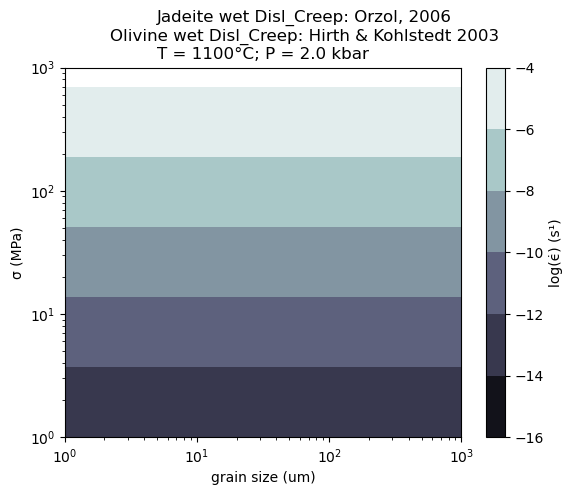

In [11]:
#d_σ_map(dis_ID, diff_ID, T_C, P=500, d_min=0, d_max=4, σ_min=-1, σ_max=3, png=False):
#d_σ_map(2,6,750, σ_min=0, σ_max=4)
d_σ_map(31,36,1100, P=200, d_min=0, d_max=3, σ_min=0, σ_max=3)

In [12]:
def σ_ϵ_full(fl_IDs, T_C, P=500, σ_min=-1, σ_max=3, d_plot=2):
    fl_IDs=np.array(fl_IDs)
    T = T_C + 273.15 #temperature degrees C
    R = 8.314 #gas constant
    leglab= '{0} {1}: {2}'
    
    σ_range = np.linspace(σ_min, σ_max, 100)
    σ_range = np.power(10,σ_range)
    d_plot = m.pow(10,d_plot)

    fugacity = PSfugacity(P*10, T)/10 #fugacity, need to convert input P to bars (hence P*10),
    #and output fogacity back to MPa (hence/10)
    
    for i in range(0,fl_IDs.shape[0]):
        if flow_laws.Flow_Law[fl_IDs[i]]=='Peierles':
            ϵ_out = m.pow(10,flow_laws.logA[fl_IDs[i]]) * np.power((σ_range/35000), flow_laws.n[fl_IDs[i]])\
                * np.exp((-1*(1000*flow_laws.Q[fl_IDs[i]])/(8.314*T))*np.power(1-(σ_range/2420),1.18))
        else:
            ϵ_out = m.pow(10,flow_laws.logA[fl_IDs[i]]) * np.power(σ_range, flow_laws.n[fl_IDs[i]])\
                * np.power(d_plot, -1*flow_laws.m[fl_IDs[i]])* m.pow(fugacity, flow_laws.r[fl_IDs[i]])\
                * m.exp(-1*(1000*flow_laws.Q[fl_IDs[i]]+(P*flow_laws.V[fl_IDs[i]]))/(8.314*T))
        plt.plot(ϵ_out, σ_range, label=leglab.format(flow_laws.Mineral[fl_IDs[i]], flow_laws.Flow_Law[fl_IDs[i]], flow_laws.Reference[fl_IDs[i]]))
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('ϵ\u0307 (s\u207B\u00B9)')
        plt.ylabel('σ (MPa)')
        plt.legend(loc='lower right', fontsize=8)
        #plt.title(T, fH2O, P, d, etc...)

In [13]:
#Output flow law data for use in ASPECT (normalized to Pa instead of MPa)
#This also normalizes Q and V
def pow_law_aspect(fl_IDs, T_C, P=500, d=100, merged=True):
    fl_IDs=np.array(fl_IDs)
    T = T_C + 273.15 #temperature degrees C
    R = 8.314 #gas constant
    header= '{0} {1}: {2}'


    fugacity = PSfugacity(P*10, T)/10 #fugacity, need to convert input P to bars (hence P*10),
    #and output fogacity back to MPa (hence/10)
    if merged==True:
        data_out='\
                  merged_prefactor = {0}\n\
                  stress_exponent = {1}\n\
                  activation_energy = {2}\n\
                  activation_volume = {3}\n'
        for i in range(0,fl_IDs.shape[0]):
            stress_exponent=flow_laws.n[fl_IDs[i]]
            activation_energy=flow_laws.Q[fl_IDs[i]] * 1e3
            activation_volume=flow_laws.V[fl_IDs[i]]/1e6
            full_condensed = m.pow(10,flow_laws.logA[fl_IDs[i]]) * m.pow(d/1e6, -1*flow_laws.m[fl_IDs[i]]) * m.pow(fugacity*1e6,flow_laws.r[fl_IDs[i]])\
                            / (m.pow(1e6,flow_laws.n[fl_IDs[i]]) * m.pow(1e6,flow_laws.m[fl_IDs[i]]) * m.pow(1e6,flow_laws.r[fl_IDs[i]]))
            print(header.format(flow_laws.Mineral[fl_IDs[i]], flow_laws.Flow_Law[fl_IDs[i]], flow_laws.Reference[fl_IDs[i]]))
            print(data_out.format(full_condensed, stress_exponent, activation_energy, activation_volume))
    else:
        data_out='\
                  prefactor = {0}\n\
                  stress_exponent = {1}\n\
                  activation_energy = {2}\n\
                  activation_volume = {3}\n\
                  fugacity exponent (r/n) = {4}\n'  
        for i in range(0,fl_IDs.shape[0]):
            stress_exponent=flow_laws.n[fl_IDs[i]]
            activation_energy=flow_laws.Q[fl_IDs[i]] * 1e3
            activation_volume=flow_laws.V[fl_IDs[i]]/1e6
            prefactor = m.pow(10,flow_laws.logA[fl_IDs[i]]) * m.pow(d/1e6, -1*flow_laws.m[fl_IDs[i]])\
                            / (m.pow(1e6,flow_laws.n[fl_IDs[i]])* m.pow(1e6,flow_laws.m[fl_IDs[i]]))
            fugacity_exponent = flow_laws.r[fl_IDs[i]] / flow_laws.n[fl_IDs[i]]
            print(header.format(flow_laws.Mineral[fl_IDs[i]], flow_laws.Flow_Law[fl_IDs[i]], flow_laws.Reference[fl_IDs[i]]))
            print(data_out.format(prefactor, stress_exponent, activation_energy, activation_volume, fugacity_exponent))
        #plt.title(T, fH2O, P, d, etc...)

In [14]:
pow_law_aspect([5,6], 900, P=2000, d=1000, merged=True)

Anorthite Disl_Creep: Rybacki & Dresen 2000
                  merged_prefactor = 3.9810717055349734e-16
                  stress_exponent = 3.0
                  activation_energy = 356000.0
                  activation_volume = 0.0

Anorthite Disl_Creep: Rybacki et al 2006
                  merged_prefactor = 2.0240877098665857e-14
                  stress_exponent = 3.0
                  activation_energy = 345000.0
                  activation_volume = 3.8e-05



In [15]:
#function to plot differential stress (σ) vs strain rate (ϵ_dot) and σ vs viscosity (η)
#utilizes the Tony Withers water fugacity calculator
#can do power law and LTP flow laws. 
#fl_IDs: one or more flow laws as comma separated array [0,1,2, etc...]
#T_C: temp in degrees C
#P: confining pressure in MPa
#σ_min, σ_max: exponent of differential stress in MPa (3=1000 MPa)
#d_plot: grain size exponent in um (3=1000um)
#m_frac: melt fraction
#alpha: value used for melt frac constant
def σ_ϵ_η_full(fl_IDs, T_C, P=500, σ_min=-1, σ_max=3, d_plot=2, m_frac=0, alpha=27,
               pdf=False, png=False, plot=True, output=False, precision=100):
    fl_IDs=np.array(fl_IDs)
    T = T_C + 273.15 #temperature degrees C
    R = 8.314 #gas constant
    leglab= '{0} {1}: {2}'
    savelab = 'stress_strain_visc_T{0}_P{1}_gs{2}_mf{3}.pdf'
    
    σ_range = np.linspace(σ_min, σ_max, precision)
    σ_range = np.power(10,σ_range)
    d_plot = m.pow(10,d_plot)

    fugacity = PSfugacity(P*10, T)/10 #fugacity, need to convert input P to bars (hence P*10),
    #and output fogacity back to MPa (hence/10)
    if plot:
        figs, ax = plt.subplots(1,2, figsize=(10,5))
        ax1=ax[0]
        ax2=ax[1]
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('ϵ\u0307 (s\u207B\u00B9)')
        ax1.set_ylabel('σ (MPa)')
        ax1.set_ylim(m.pow(10,σ_min), m.pow(10,σ_max))

        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('η (Pa s)')
        ax2.set_ylabel('σ (MPa)')
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
        ax2.set_ylim(m.pow(10,σ_min), m.pow(10,σ_max))
        
    for i in range(0,fl_IDs.shape[0]):
        if flow_laws.Flow_Law[fl_IDs[i]]=='Peierles':
            ϵ_out = m.pow(10,flow_laws.logA[fl_IDs[i]]) * np.power((σ_range/35000), flow_laws.n[fl_IDs[i]])\
                * np.exp((-1*(1000*flow_laws.Q[fl_IDs[i]])/(8.314*T))*np.power(1-(σ_range/2420),1.18))
        else:
            ϵ_out = m.pow(10,flow_laws.logA[fl_IDs[i]]) * np.power(σ_range, flow_laws.n[fl_IDs[i]])\
                * np.power(d_plot, -1*flow_laws.m[fl_IDs[i]])* m.pow(fugacity, flow_laws.r[fl_IDs[i]])\
                * m.exp(-1*(1000*flow_laws.Q[fl_IDs[i]]+(P*flow_laws.V[fl_IDs[i]]))/(8.314*T))\
                * m.exp(alpha*m_frac)
        if plot:
            lines=['-', '--', '-.', ':']
            colors=['black', 'red', 'blue', 'green', 'orange', 'purple']
            linecol=i%6
            linesty=i%4
            ax1.plot(ϵ_out, σ_range, ls=lines[linesty], c=colors[linecol],\
                     label=leglab.format(flow_laws.Mineral[fl_IDs[i]],\
                                         flow_laws.Flow_Law[fl_IDs[i]], flow_laws.Reference[fl_IDs[i]]))
            ax2.plot(1e6*σ_range/(2*ϵ_out), σ_range, ls=lines[linesty], c=colors[linecol])
            ax1.legend(loc='center', bbox_to_anchor=(1.1, -.25), edgecolor='0',fontsize=8)
            #ax1.legend(loc='upper left', edgecolor='0',fontsize=8)
            plt.suptitle(f'T={T_C} \u00B0C; P={P/100} kbar')
    if output:
        return σ_range, ϵ_out
    if pdf:
        plt.savefig(savelab.format(T_C, P, int(d_plot),int(m_frac*100)))

In [28]:
flow_laws.loc[flow_laws['Mineral']=='Antigorite']

,ID,Mineral,H2O,Min_Mode,Flow_Law,logA,n,Q,m,r,V,Reference
11,11,Antigorite,NaN,100Atg,Disl_Creep,-14.587,3.8,8.9,0.0,0.0,3.2,Hilairet et al 2007
12,12,Antigorite,NaN,100Atg,Peierles,-0.271,2.0,86.3,0.0,0.0,0.0,Burdette & Hirth 2022


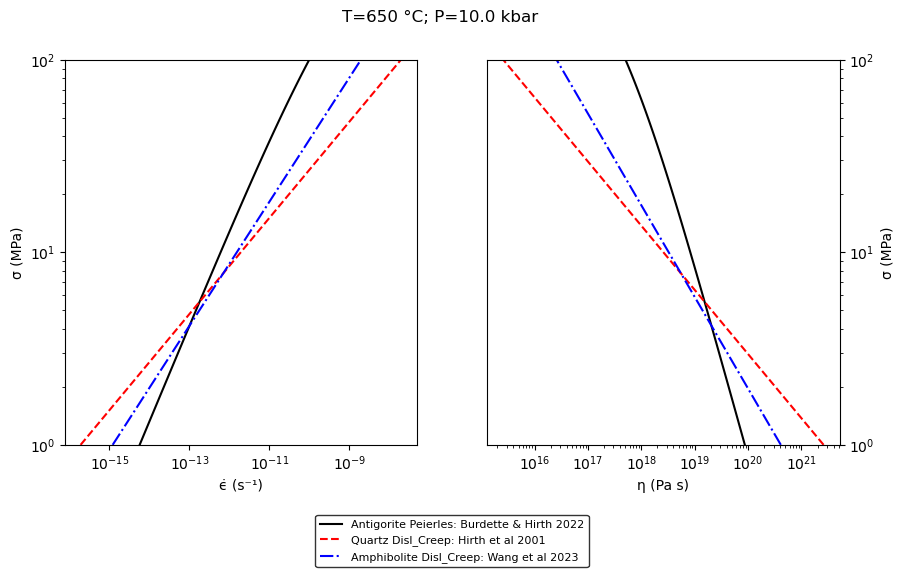

In [40]:
σ_ϵ_η_full([12, 45,52], 650, P=1000, σ_min=0, σ_max=2, d_plot=2, m_frac=0, alpha=27,
               pdf=False, png=False, plot=True, output=False, precision=100)

In [17]:
np.linspace(200,700,101)

array([200., 205., 210., 215., 220., 225., 230., 235., 240., 245., 250.,
       255., 260., 265., 270., 275., 280., 285., 290., 295., 300., 305.,
       310., 315., 320., 325., 330., 335., 340., 345., 350., 355., 360.,
       365., 370., 375., 380., 385., 390., 395., 400., 405., 410., 415.,
       420., 425., 430., 435., 440., 445., 450., 455., 460., 465., 470.,
       475., 480., 485., 490., 495., 500., 505., 510., 515., 520., 525.,
       530., 535., 540., 545., 550., 555., 560., 565., 570., 575., 580.,
       585., 590., 595., 600., 605., 610., 615., 620., 625., 630., 635.,
       640., 645., 650., 655., 660., 665., 670., 675., 680., 685., 690.,
       695., 700.])

In [18]:
def σ_ϵ_intercept(fl_ID1,fl_ID2, slope, intercept, Tmin=200, Tmax=700, σ_min=-1, σ_max=3,\
                  precision=100, index_ϵ=1e-12):
    T_range=np.linspace(Tmin, Tmax, 101)
    P_range=(slope*(T_range+273)+intercept)/10 #MPa
    
    isovisc_ϵ=np.zeros(len(T_range))
    isovisc_σ=np.zeros(len(T_range))
    Δη=np.zeros(len(T_range))
    for i in range(len(T_range)):
        σs_1, ϵs_1 = σ_ϵ_η_full([fl_ID1], T_range[i], P=P_range[i], d_plot=1, σ_min=σ_min,σ_max=σ_max,\
                                plot=False, output=True, precision=precision)
        σs_2, ϵs_2 = σ_ϵ_η_full([fl_ID2], T_range[i], P=P_range[i], d_plot=1, σ_min=σ_min,σ_max=σ_max,\
                                plot=False, output=True, precision=precision)
        if np.nanmax(ϵs_1)>=index_ϵ and np.nanmax(ϵs_2)>=index_ϵ:
            Δη1_index=np.where(ϵs_1>=index_ϵ)[0][0]
            Δη2_index=np.where(ϵs_2>=index_ϵ)[0][0]
            Δη[i]=(σs_2[Δη2_index]*1e6/(2*ϵs_2[Δη2_index]))/(σs_1[Δη1_index]*1e6/(2*ϵs_1[Δη1_index]))
        else:
            Δη[i]=np.nan
        if len(np.where(ϵs_1>ϵs_2)[0])>0 and len(np.where(ϵs_1<ϵs_2)[0])>0:
            x_over = max(np.where(ϵs_1>ϵs_2)[0][0], np.where(ϵs_1<ϵs_2)[0][0])
            if np.where(ϵs_1>ϵs_2)[0][0] > np.where(ϵs_1<ϵs_2)[0][0]:
                isovisc_ϵ[i]=ϵs_1[x_over]
                isovisc_σ[i]=σs_1[x_over]
            elif np.where(ϵs_1>ϵs_2)[0][0] < np.where(ϵs_1<ϵs_2)[0][0]:
                isovisc_ϵ[i]=ϵs_2[x_over]
                isovisc_σ[i]=σs_2[x_over]
            else:
                isovisc_ϵ[i]=np.nan
                isovisc_σ[i]=np.nan
        else:
            isovisc_ϵ[i]=np.nan
            isovisc_σ[i]=np.nan
    return isovisc_ϵ, isovisc_σ, T_range, P_range, Δη

In [19]:

isovisc_sr, isovisc_sh, T_range, P_range, Δη= σ_ϵ_intercept(45,52,14.6908,-4009.58, Tmin=200, Tmax=1000, precision=1000)

In [20]:
slopes=[11.76,14.6985, 19.5985]

In [21]:
#ϵ_points=1e-13
R=8.314
ϵ_points=np.array([1e-14, 1e-13, 1e-12, 1e-11])
T_points=np.arange(473,1281,8,dtype=float)
P_points=np.arange(2000,25230, 230,dtype=float)
Δη_points=np.zeros((101,101, 4))
for h in range(len(ϵ_points)):
    for i in range(len(P_points)):
        for j in range(len(T_points)):
            T_K=T_points[j]
            P_bars=P_points[i]
            P_MPa=P_points[i]/10
            H2O_fug=PSfugacity(P_bars, T_K)/10
            σ_points1=(ϵ_points[h]/(10**-6.2))**(1/3.1)*m.exp(154000/(3.1*R*T_K))
            σ_points2=(ϵ_points[h]/(10**-11.2*H2O_fug))**(1/4)*m.exp(135000/(4*R*T_K))
            Δη_i=(σ_points1*1e6/(2*ϵ_points[h]))/(σ_points2*1e6/(2*ϵ_points[h]))
            Δη_points[i,j,h]=Δη_i
        

In [24]:
def exp_fit(xx,a,c):
    return a*xx**(c)
xx = shear_values1[:,0]
yy = shear_values1[:,1]
popt, pcov = curve_fit(exp_fit, xx,yy,p0=(0,0))

In [ ]:
popt[0]

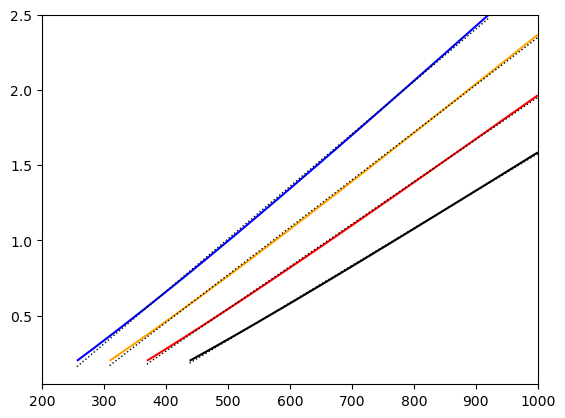

In [23]:
#plt.contourf(T_points-273,P_points/10000,np.log10(Δη_points))
#plt.colorbar()
shear_data1=plt.contour(T_points-273,P_points/10000,Δη_points[:,:,0], levels=[1], colors='blue')
shear_data2=plt.contour(T_points-273,P_points/10000,Δη_points[:,:,1], levels=[1], colors='orange')
shear_data3=plt.contour(T_points-273,P_points/10000,Δη_points[:,:,2], levels=[1], colors='r')
shear_data4=plt.contour(T_points-273,P_points/10000,Δη_points[:,:,3], levels=[1], colors='k')
#plt.xlim(200,1000)
#plt.ylim(.2,2.5)
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy.stats import linregress
shear_values1=shear_data1.collections[0].get_paths()[0].vertices[:]
shear_values2=shear_data2.collections[0].get_paths()[0].vertices[:]
shear_values3=shear_data3.collections[0].get_paths()[0].vertices[:]
shear_values4=shear_data4.collections[0].get_paths()[0].vertices[:]
stats1=linregress(shear_values1[:,0], shear_values1[:,1])
stats2=linregress(shear_values2[:,0], shear_values2[:,1])
stats3=linregress(shear_values3[:,0], shear_values3[:,1])
stats4=linregress(shear_values4[:,0], shear_values4[:,1])
plt.plot(shear_values1[:,0], shear_values1[:,0]*stats1.slope+stats1.intercept, c='k', ls=':', lw=1)
plt.plot(shear_values2[:,0], shear_values2[:,0]*stats2.slope+stats2.intercept, c='k', ls=':', lw=1)
plt.plot(shear_values3[:,0], shear_values3[:,0]*stats3.slope+stats3.intercept, c='k', ls=':', lw=1)
plt.plot(shear_values4[:,0], shear_values4[:,0]*stats4.slope+stats4.intercept, c='k', ls=':', lw=1)

In [207]:
print(stats1.slope, stats1.intercept)
print(stats2.slope, stats2.intercept)
print(stats3.slope, stats3.intercept)
print(stats4.slope, stats4.intercept)

0.0034865630054384277 -0.7336696480897946
0.0031569613406692374 -0.808249933804853
0.002813520718492567 -0.8618191030109295
0.0024775435561466717 -0.9012013534190662


In [186]:
stats.rvalue**2

0.9996854026383548

Text(0, 0.5, 'pressure (GPa)')

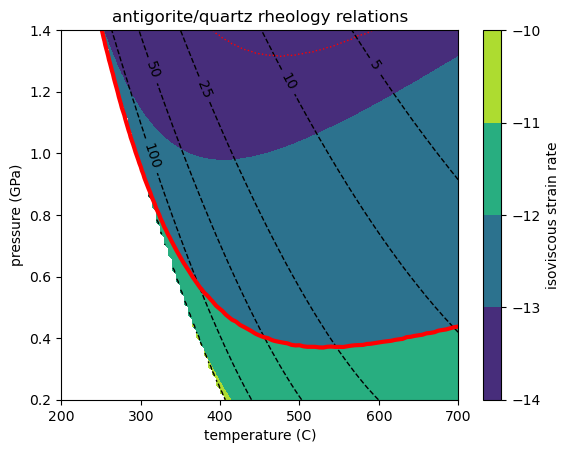

In [21]:
contour_grid=np.zeros((101,101,3))
for i in range(101):
    intercept_i=2000+i*120
    slope_i=0
    isovisc_sr, isovisc_sh, T_range, P_range, Δη = σ_ϵ_intercept(45,12,slope_i, intercept_i,\
                                                                 Tmin=200, Tmax=700, precision=10000,\
                                                                index_ϵ=1e-12)
    contour_grid[i,:,0]=isovisc_sr
    contour_grid[i,:,1]=isovisc_sh
    contour_grid[i,:,2]=Δη
    
    
plt.contourf(np.linspace(200,700,101), np.linspace(0.2,1.4,101), np.log10(contour_grid[:,:,0]),\
           levels=[-14, -13, -12, -11, -10])
plt.colorbar(label='isoviscous strain rate')
CS=plt.contour(np.linspace(200,700,101), np.linspace(0.2,1.4,101), contour_grid[:,:,1],\
            levels=[5, 10, 25, 50, 100, 200], colors='k', linewidths=1, linestyles='--')
plt.contour(np.linspace(200,700,101), np.linspace(0.2,1.4,101), contour_grid[:,:,2], levels=[1],\
            colors='r', linewidths=3)
plt.contour(np.linspace(200,700,101), np.linspace(0.2,1.4,101), contour_grid[:,:,2], levels=[2],\
            colors='r', linewidths=1, linestyles=':')
plt.clabel(CS,fontsize=10)
plt.title('antigorite/quartz rheology relations')
plt.xlabel('temperature (C)')
plt.ylabel('pressure (GPa)')

<a list of 6 text.Text objects>

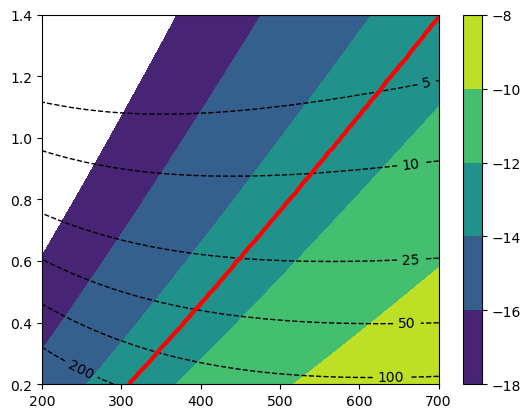

In [88]:
contour_grid=np.zeros((101,101,3))
for i in range(101):
    intercept_i=2000+i*120
    slope_i=0
    isovisc_sr, isovisc_sh, T_range, P_range, Δη = σ_ϵ_intercept(45,52,slope_i, intercept_i,\
                                                                 Tmin=200, Tmax=700, precision=10000,\
                                                                 index_ϵ=1e-13)
    if intercept_i==10040:
        Δη_FS13=Δη
    contour_grid[i,:,0]=isovisc_sr
    contour_grid[i,:,1]=isovisc_sh
    contour_grid[i,:,2]=Δη
    
    
plt.contourf(np.linspace(200,700,101), np.linspace(0.2,1.4,101), np.log10(contour_grid[:,:,0]),\
           levels=[-18, -16, -14, -12, -10, -8])
plt.colorbar()
CS=plt.contour(np.linspace(200,700,101), np.linspace(0.2,1.4,101), contour_grid[:,:,1],\
            levels=[5, 10, 25, 50, 100, 200], colors='k', linewidths=1, linestyles='--')
plt.contour(np.linspace(200,700,101), np.linspace(0.2,1.4,101), contour_grid[:,:,2], levels=[1],\
            colors='r', linewidths=3)
plt.clabel(CS,fontsize=10)

(450.0, 650.0)

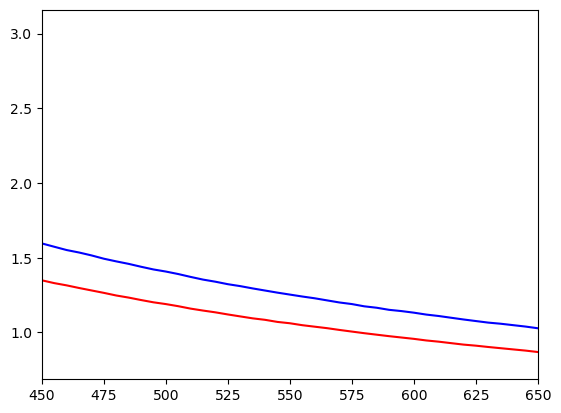

In [89]:
plt.plot(np.arange(200,705,5), Δη_FS, c='b')
plt.plot(np.arange(200,705,5), Δη_FS13, c='r')
plt.xlim(450, 650)
#plt.ylim(1.2,2.1)

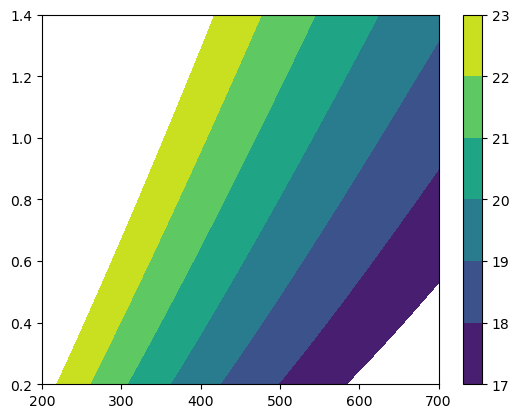

In [23]:
plt.contourf(np.linspace(200,700,101), np.linspace(0.2,1.4,101), np.log10(contour_grid[:,:,1]*1e6/(2*contour_grid[:,:,0])),\
             levels=[17,18,19,20,21,22,23])
plt.colorbar()

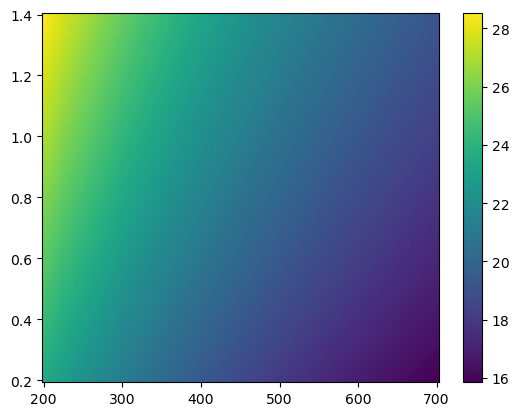

In [24]:
plt.pcolormesh(np.linspace(200,700,101), np.linspace(0.2,1.4,101), np.log10(contour_grid[:,:,1]*1e6/(2*contour_grid[:,:,0])))
plt.colorbar()

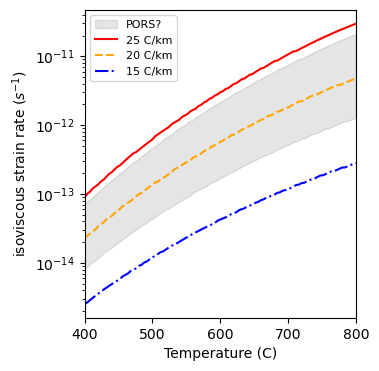

In [27]:
slopes=[11.76,14.6985, 19.5985]
intercepts=[-3209.48, -4011.68, -5349.38]
therm_grads=[25,20,15]
lcolors=['r', 'orange', 'b','k','g']
lstyles=['-','--','-.',':']
isovisc_sr_h, isovisc_sh_h, T_range_h, P_range_h, Δη = σ_ϵ_intercept(45,52,12.30615,-3358.58,\
                                                            Tmin=400, Tmax=800, precision=1000)
isovisc_sr_l, isovisc_sh_l, T_range_l, P_range_l, Δη = σ_ϵ_intercept(45,52,16.9215,-4618.58,\
                                                            Tmin=400, Tmax=800, precision=1000)
fig, ax=plt.subplots(figsize=(3.5,4))
ax.fill_between(T_range_h,isovisc_sr_h, isovisc_sr_l, color='k', alpha=0.1, label='PORS?', zorder=0)
for i in range(len(slopes)):
    isovisc_sr, isovisc_sh, T_range, P_range, Δη = σ_ϵ_intercept(45,52,slopes[i],intercepts[i],\
                                                            Tmin=400, Tmax=800, precision=1000)
    ax.plot(T_range, isovisc_sr, c=lcolors[i%len(lcolors)],\
             ls=lstyles[i%len(lstyles)], label=f'{therm_grads[i]} C/km', zorder=1)
ax.set_yscale('log')
ax.set_xlim(400, 800)
ax.set_ylabel('isoviscous strain rate ($s^{-1}$)')
ax.set_xlabel('Temperature (C)')
ax.legend(fontsize=8)
plt.savefig('isoviscous_strain_rate.pdf')

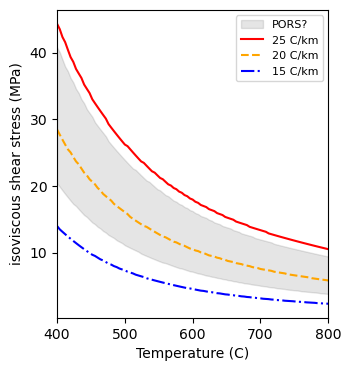

In [28]:
slopes=[11.76,14.6985, 19.5985]
intercepts=[-3209.48, -4011.68, -5349.38]
therm_grads=[25,20,15]
lcolors=['r', 'orange', 'b','k','g']
lstyles=['-','--','-.',':']
isovisc_sr_h, isovisc_sh_h, T_range_h, P_range_h, Δη = σ_ϵ_intercept(45,52,12.30615,-3358.58,\
                                                            Tmin=400, Tmax=800, precision=1000)
isovisc_sr_l, isovisc_sh_l, T_range_l, P_range_l, Δη = σ_ϵ_intercept(45,52,16.9215,-4618.58,\
                                                            Tmin=400, Tmax=800, precision=1000)
fig, ax=plt.subplots(figsize=(3.5,4))
ax.fill_between(T_range_h,isovisc_sh_h, isovisc_sh_l, color='k', alpha=0.1, label='PORS?', zorder=0)
for i in range(len(slopes)):
    isovisc_sr, isovisc_sh, T_range, P_range, Δη = σ_ϵ_intercept(45,52,slopes[i],intercepts[i],\
                                                            Tmin=400, Tmax=800, precision=1000)
    ax.plot(T_range, isovisc_sh, c=lcolors[i%len(lcolors)],\
             ls=lstyles[i%len(lstyles)], label=f'{therm_grads[i]} C/km', zorder=1)
#ax.set_yscale('log')
ax.set_xlim(400, 800)
ax.set_ylabel('isoviscous shear stress (MPa)')
ax.set_xlabel('Temperature (C)')
ax.legend(fontsize=8)
plt.savefig('isoviscous_shear_stress.pdf')

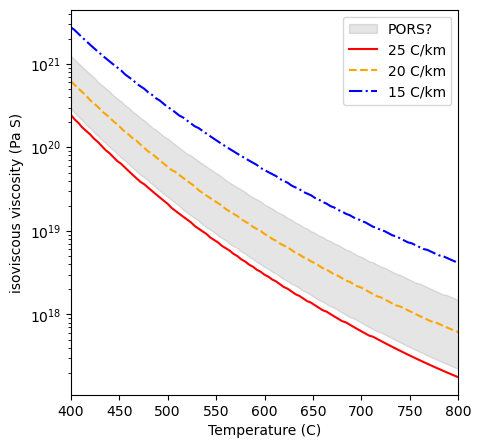

In [29]:
slopes=[11.76,14.6985, 19.5985]
intercepts=[-3209.48, -4011.68, -5349.38]
therm_grads=[25,20,15]
lcolors=['r', 'orange', 'b','k','g']
lstyles=['-','--','-.',':']
isovisc_sr_h, isovisc_sh_h, T_range_h, P_range_h, Δη = σ_ϵ_intercept(45,52,12.30615,-3358.58,\
                                                            Tmin=400, Tmax=800, precision=1000)
isovisc_sr_l, isovisc_sh_l, T_range_l, P_range_l, Δη = σ_ϵ_intercept(45,52,16.9215,-4618.58,\
                                                            Tmin=400, Tmax=800, precision=1000)
fig, ax=plt.subplots(figsize=(5,5))
ax.fill_between(T_range_h,isovisc_sh_h*1e6/(2*isovisc_sr_h), isovisc_sh_l*1e6/(2*isovisc_sr_l), color='k', alpha=0.1, label='PORS?', zorder=0)
for i in range(len(slopes)):
    isovisc_sr, isovisc_sh, T_range, P_range, Δη = σ_ϵ_intercept(45,52,slopes[i],intercepts[i],\
                                                            Tmin=400, Tmax=800, precision=1000)
    ax.plot(T_range, isovisc_sh*1e6/(2*isovisc_sr), c=lcolors[i%len(lcolors)],\
             ls=lstyles[i%len(lstyles)], label=f'{therm_grads[i]} C/km', zorder=1)
ax.set_yscale('log')
ax.set_xlim(400, 800)
ax.set_ylabel('isoviscous viscosity (Pa S)')
ax.set_xlabel('Temperature (C)')
ax.legend()
plt.savefig('isoviscous_viscosity.pdf')

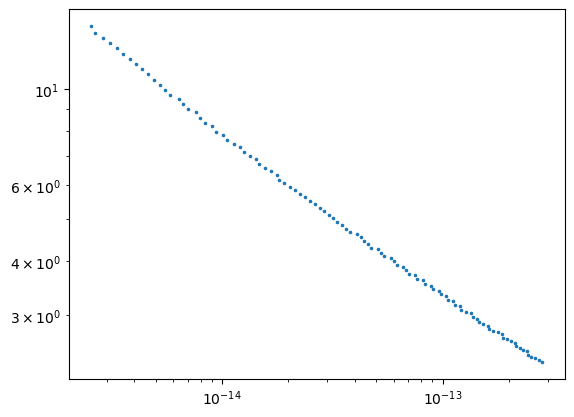

In [30]:
plt.scatter(isovisc_sr, isovisc_sh, edgecolors=None, marker='.', s=10)
plt.yscale('log')
plt.xscale('log')

In [105]:
P_est=np.array([10,12,11,9,10,9,8])

In [100]:
sigma_range, epsilon_range = σ_ϵ_η_full([13], 650, P=750, d_plot=1, σ_min=-1,σ_max=2, plot=False, output=True)

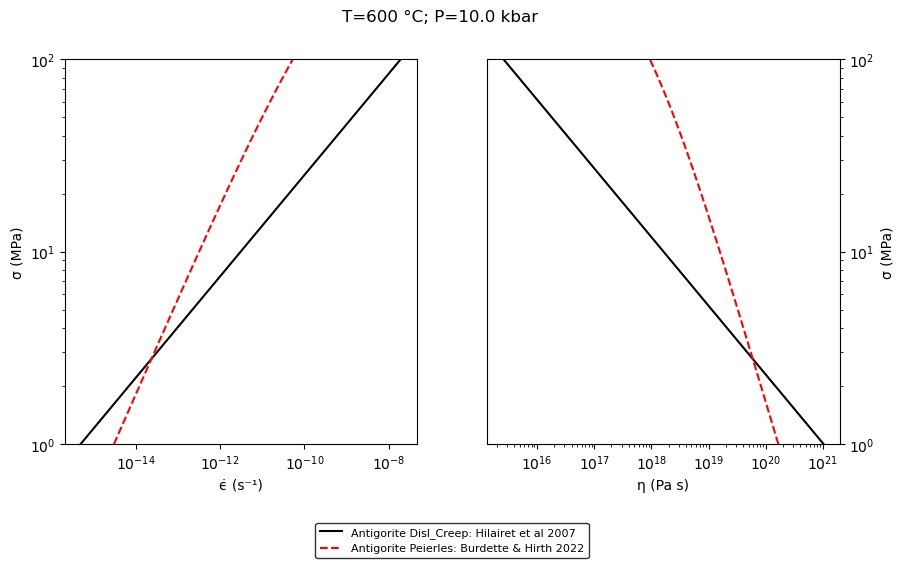

In [20]:
σ_ϵ_η_full([11,12], 600, P=1000, d_plot=1, σ_min=0,σ_max=2, m_frac=0.0)

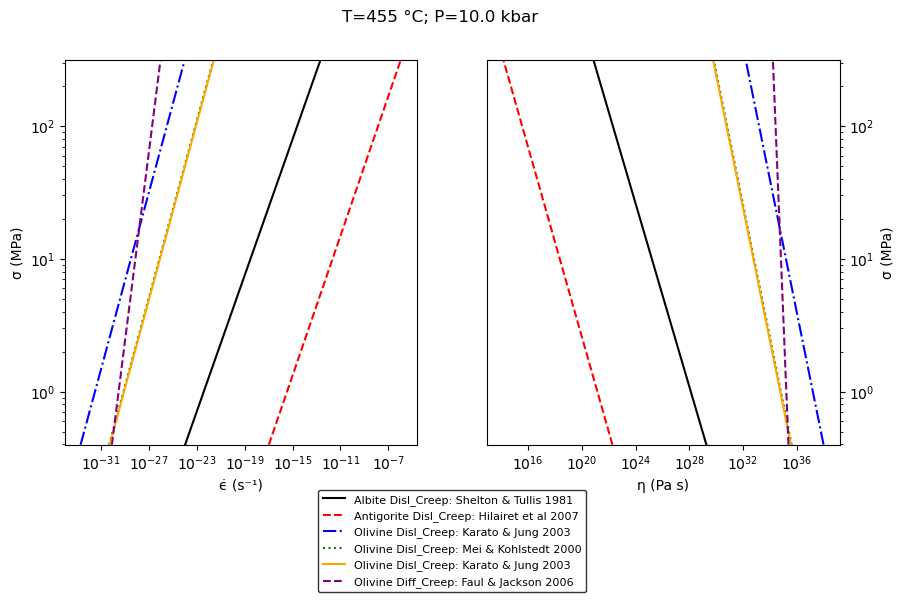

In [168]:
σ_ϵ_η_full([1, 11, 34, 35,37,39], 728-273, P=1000, d_plot=m.log10(50), σ_min=-0.4, 
           σ_max=2.5, m_frac=0)

In [22]:
def σ_T_full(fl_IDs, T_start=300, T_end=800, P=500, σ_min=-1, σ_max=2, d_plot=2):
    fl_IDs=np.array(fl_IDs)
    T_C=np.linspace(T_start, T_end, 100)
    T = T_C + 273.15 #temperature degrees C
    R = 8.314 #gas constant
    leglab= '{0} {1}: {2}'
    σ_range = np.linspace(σ_max, σ_min, 100)
    σ_range = np.power(10,σ_range)
    d_plot = m.pow(10,d_plot)

    fugacity = np.zeros(T.shape[0])
    for h in range (0,T.shape[0]):
        fugacity[h] = PSfugacity(P*10, T[h])/10 #fugacity, need to convert input P to bars (hence P*10),
    #and output fogacity back to MPa (hence/10)
    
    figs, ax = plt.subplots(1,2)
    ax1=ax[0]
    ax2=ax[1]
    ax1.set_xscale('log')
    ax1.set_ylim(T_end, T_start)
    ax1.set_xlabel('ϵ\u0307 (s\u207B\u00B9)')
    ax1.set_ylabel('T (C)')
    
    ax2.set_xscale('log')
    ax2.set_ylim(T_end, T_start)
    ax2.set_xlabel('η (Pa s)')
    
    for i in range(0,fl_IDs.shape[0]):
        if flow_laws.Flow_Law[fl_IDs[i]]=='Peierles':
            ϵ_out = m.pow(10,flow_laws.logA[fl_IDs[i]]) * np.power((σ_range/35000), flow_laws.n[fl_IDs[i]])\
                * np.exp((-1*(1000*flow_laws.Q[fl_IDs[i]])/(8.314*T))*np.power(1-(σ_range/2420),1.18))
        else:
            ϵ_out = m.pow(10,flow_laws.logA[fl_IDs[i]]) * np.power(σ_range, flow_laws.n[fl_IDs[i]])\
                * np.power(d_plot, -1*flow_laws.m[fl_IDs[i]])* np.power(fugacity, flow_laws.r[fl_IDs[i]])\
                * np.exp(-1*(1000*flow_laws.Q[fl_IDs[i]]+(P*flow_laws.V[fl_IDs[i]]))/(8.314*T))

        ax1.plot(ϵ_out, T_C, label=leglab.format(flow_laws.Mineral[fl_IDs[i]], flow_laws.Flow_Law[fl_IDs[i]], flow_laws.Reference[fl_IDs[i]]))
        ax2.plot(1e6*σ_range/(2*ϵ_out), T_C)
        #plt.title(T, fH2O, P, d, etc...)
        ax1.legend(fontsize=8)

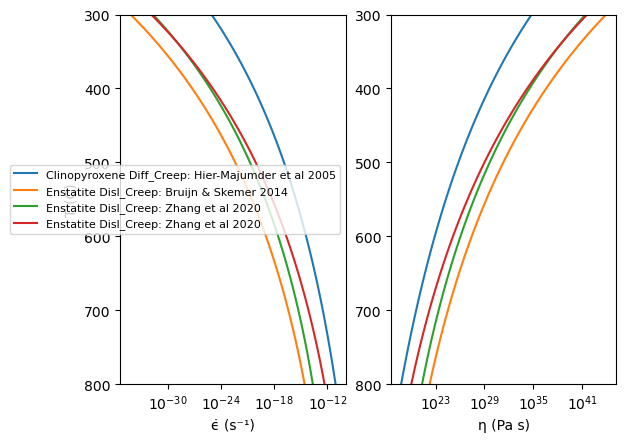

In [23]:
σ_T_full([19, 25, 26, 27], T_start=300, T_end=800, σ_min=2, σ_max=4)

In [24]:
def σ_depth(fl_IDs, SZ_ID=1, linear=False, ϵ=1e-12, d_plot=2, x_min=0.1, x_max=1000, λ=0.4,
            y_min=0, y_max=700, xlogs=False, ylogs=False, yplot='T'):
    fl_IDs=np.array(fl_IDs)
    R = 8.314 #gas constant
    leglab= '{0} {1}: {2}'
    if linear != False:
        if linear =='Ocean':
            Z=np.arange(0,150000, 1000)
            T=special.erf(Z/(2*(1e-6*1.90608e15)**0.5))*1300+273.15
            Z=Z/1000
            P=Z*32.34
        else:
            Z=np.linspace(0,100,100) #Depth in km
            T=Z*linear+273.15 #Temperature in K
            P=Z*32.34 #pressure in MPa
    else:
        fload='pvk_thermal/{}.xls'
        PT=pd.read_excel(fload.format(SZ_ID))
        T=PT['T'].to_numpy()
        P=PT['P'].to_numpy()
        P=P*1000
        T=T+273.15
        Z= P/32.34
    d_plot = m.pow(10,d_plot)

    fugacity = np.zeros(T.shape[0])
    for h in range (0,T.shape[0]):
        fugacity[h] = PSfugacity(int(P[h]*10), T[h])/10 #fugacity, need to convert input P to bars (hence P*10),
    #and output fogacity back to MPa (hence/10)
    #figs, ax = plt.subplots(1,2)
    #ax1=ax[0]
    #ax2=ax[1]
    #ax1.set_xscale('log')
    #ax1.set_yscale('log')
    #ax1.set_xlabel('ϵ\u0307 (s\u207B\u00B9)')
    #ax1.set_ylabel('σ (MPa)')
    
    #ax2.set_xscale('log')
    #ax2.set_yscale('log')
    #ax2.set_xlabel('η (Pa s)')
    #ax2.set_ylabel('σ (MPa)')
    if yplot =='Z':
        plt.plot(P*0.85*(1-λ), Z,label='Byerlees Law')
    else:
        plt.plot(P*0.85*(1-λ), T-273.15,label='Byerlees Law')
        
        
    for i in range(0,fl_IDs.shape[0]):
        if flow_laws.Flow_Law[fl_IDs[i]]=='Peierles':
            σ_out = np.zeros(T.shape[0])
            for j in range(0, T.shape[0]):
                σ_out[j] = LTP_γ(fl_IDs[i], T[j], ϵ)
        else:
            σ_out = np.power(ϵ * m.pow(d_plot, flow_laws.m[fl_IDs[i]]) / (m.pow(10,flow_laws.logA[fl_IDs[i]]) * np.power(fugacity, flow_laws.r[fl_IDs[i]])),(1/flow_laws.n[fl_IDs[i]]))\
                * np.exp((1000*flow_laws.Q[fl_IDs[i]]+(P*flow_laws.V[fl_IDs[i]]))/(flow_laws.n[fl_IDs[i]]*8.314*T))
            #σ_out = σ_out*m.exp(-2.7/flow_laws.n[fl_IDs[i]]) #0.1 melt fraction
        if yplot == 'T':
            plt.plot(σ_out, T-273.15, label=leglab.format(flow_laws.Mineral[fl_IDs[i]], flow_laws.Flow_Law[fl_IDs[i]], flow_laws.Reference[fl_IDs[i]]))
            plt.ylim(y_max,y_min)
        elif yplot == 'Z':
            plt.plot(σ_out, Z, label=leglab.format(flow_laws.Mineral[fl_IDs[i]], flow_laws.Flow_Law[fl_IDs[i]], flow_laws.Reference[fl_IDs[i]]))
            if yplot =='Z' and y_max == 700 and y_min == 0:
                plt.ylim(y_max/10, y_min)
            elif yplot =='Z' and y_max >= 300:
                plt.ylim(y_max/10, y_min)
            else:
                plt.ylim(y_max, y_min)
        #ax2.plot(2*σ_range/ϵ_out, σ_range)
        plt.xlim(x_min,x_max)
        
        if xlogs==True:
            plt.xscale('log')
        if ylogs==True:
            plt.yscale('log')
        plt.legend(loc='lower right', fontsize=8)
        #plt.savefig('L_2GPa_1e14_legend.pdf')
        #plt.title(T, fH2O, P, d, etc...)

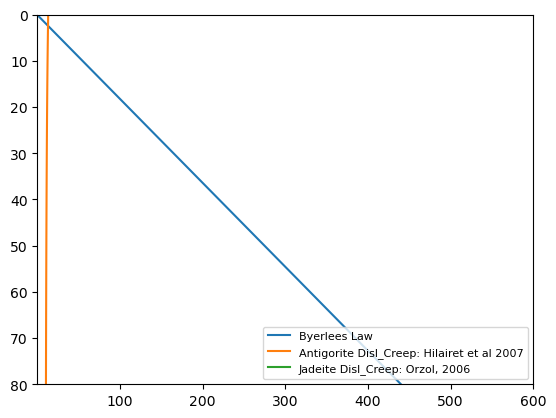

In [25]:
#σ_depth(fl_IDs, SZ_ID=1, linear=False, ϵ=1e-12, d_plot=2):
σ_depth([11, 31], linear=5, d_plot=m.log10(10), ϵ=1e-12, xlogs=False, yplot='Z', y_max=800, x_min=0.5, x_max=600, λ=0.8)

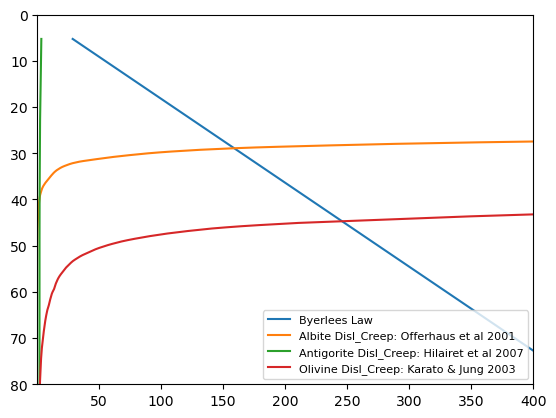

In [26]:
#σ_depth(fl_IDs, SZ_ID=1, linear=False, ϵ=1e-12, d_plot=2):
σ_depth([0, 11, 34], SZ_ID=57, linear=False, d_plot=m.log10(100), 
        ϵ=1e-14, xlogs=False, yplot='Z', y_max=800, x_min=0.5, x_max=400, λ=0.8)

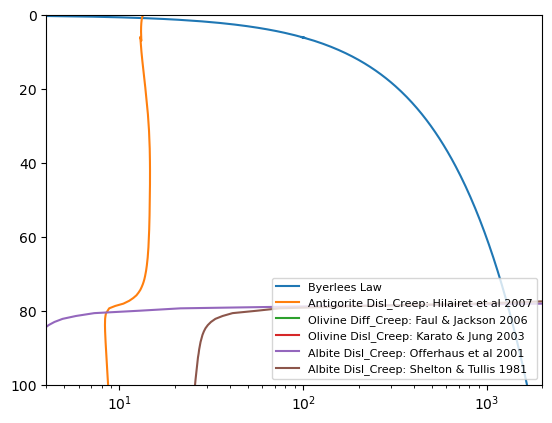

In [27]:
#σ_depth(fl_IDs, SZ_ID=1, linear=False, ϵ=1e-12, d_plot=2):
σ_depth([11, 39, 34, 0, 1], SZ_ID=35, linear=False, d_plot=2, x_min=4, x_max=2000, ϵ=1e-12, y_max=100, xlogs=True, yplot='Z')

In [90]:
def ϵ_σ_mix(ID1, ID2, T_C, P=750, d=2, σ_min=0, σ_max=3, increments=[5,25,50,75,95], model='MPGe', plotting='simple'\
            , pdf=False, png=False, embed=False):
    T = T_C+273 #K
    P = P*1e6 #Pa
    R = 8.3145

    leglab= '{0}:{1} {2}:{3}'
    savelab = 'stress_strain_visc_T{0}_P{1}_mix_{2}.{3}_{4}.{5}.pdf'
    savelab2 = 'stress_strain_visc_T{0}_P{1}_mix_{2}.{3}_{4}.{5}.png'
    σ_range = np.linspace(σ_min+6, σ_max+6, 100)
    σ_range = np.power(10,σ_range)
    d = m.pow(10,d)
    
    #phase 1 data
    A1=10**flow_laws.logA[ID1]
    n1=flow_laws.n[ID1]
    Q1=flow_laws.Q[ID1]*1000
    m1=flow_laws.m[ID1]
    r1=flow_laws.r[ID1]
    V1=flow_laws.V[ID1]*1e-6
    
    #phase 2 data
    A2=10**flow_laws.logA[ID2]
    n2=flow_laws.n[ID2]
    Q2=flow_laws.Q[ID2]*1000
    m2=flow_laws.m[ID2]
    r2=flow_laws.r[ID2]
    V2=flow_laws.V[ID2]*1e-6
    
    #calculate H2O figuacity
    fh2o = PSfugacity(P/1e5, T, den_out=False)/10 #bars in MPa out
    
    fh2o1 = fh2o**r1
    fh2o2 = fh2o**r2
    
    #combine all terms outside of exponential and ϵ/σ into single term
    A_mod1 = A1*1e6**(-n1) *1e-6**m1 * fh2o1 * (1/d**m1)*1e6**m1
    A_mod2 = A2*1e6**(-n2) *1e-6**m2 * fh2o2 * (1/d**m2)*1e6**m2
    
    #combine numerator of exponential into single term
    Q_mod1 = Q1 + P*V1
    Q_mod2 = Q2 + P*V2
    
    #modified eq 3/4
    B1 = A_mod1 * m.exp(-1*Q_mod1/(R*T))   
    B2 = A_mod2 * m.exp(-1*Q_mod2/(R*T))  
    
        
    #ϕ_i - volume fractions of phases
    ϕ1 = np.linspace(0.01,0.99,99)
    ϕ2 = np.linspace(0.99, 0.01, 99)
    
    #print('fH2Os', fh2o1, fh2o2)
    #print('Merged prefactors',A_mod1, A_mod2)
    #print('merged activations', Q_mod1, Q_mod2)
    
    if model =='Tullis':
        if n1 != n2:
            n_bulk = np.power(10, (ϕ1*m.log10(n1) + ϕ2*m.log10(n2)))
            Q_bulk = (Q_mod2 * (n_bulk - n1) - Q_mod1*(n_bulk - n2))/(n2-n1)
            A_bulk = np.power(10, ((np.log10(A_mod2)*(n_bulk-n1) - np.log10(A_mod1)*(n_bulk-n2))/(n2-n1)))
        if n1 == n2:
            model = 'MPGe'
            print('Tullis model requires n1 != n2, using MPGe instead')
            
    if model =='MPGe':
        #bulk parameters: eqs: 43, 44, 47
        n_bulk = (ϕ1*(n2+1)*n1 + ϕ2*(n1+1)*n2) / (ϕ1*(n2+1)+ϕ2*(n1+1))
        Q_bulk = (ϕ1*(n2+1)*Q_mod1 + ϕ2*(n1+1)*Q_mod2) / (ϕ1*(n2+1)+ϕ2*(n1+1))
        A_bulk = ((ϕ1*n1/(n1+1))+(ϕ2*n2/(n2+1)))**(-1*n_bulk)\
                * (n1/(n1+1))**(ϕ1*(n2+1)*n1/(ϕ1*(n2+1)+ϕ2*(n1+1)))\
                * (n2/(n2+1))**(ϕ2*(n1+1)*n2/(ϕ2*(n1+1)+ϕ1*(n2+1)))\
                * A_mod1**(ϕ1*(n2+1)/(ϕ1*(n2+1)+ϕ2*(n1+1)))\
                * A_mod2**(ϕ2*(n1+1)/(ϕ2*(n1+1)+ϕ1*(n2+1))) 
    if embed==False:
        figs, ax = plt.subplots(1,2, figsize=(10,5))
        ax1=ax[0]
        ax2=ax[1]
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('ϵ\u0307 (s\u207B\u00B9)')
        ax1.set_ylabel('σ (MPa)')
        ax1.set_ylim(m.pow(10,σ_min), m.pow(10,σ_max))

        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('η (Pa s)')
        ax2.set_ylabel('σ (MPa)')
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
        ax2.set_ylim(m.pow(10,σ_min), m.pow(10,σ_max))

    for i in range(len(increments)):
        ϵ_mix = A_bulk[int(increments[i]-1)] * np.power(σ_range,n_bulk[int(increments[i]-1)])\
                * np.exp(-1*Q_bulk[int(increments[i]-1)]/(R*T))
        if embed==True:
            break
        lines=['-', '--', '-.', ':']
        colors=['#332288', '#882255', '#117733', '#AA4499', '#44AA99', '#CC6677']
        linecol=i%6
        linesty=i%4
        ax1.plot(ϵ_mix, σ_range/1e6, ls=lines[linesty], c=colors[linecol],\
                    label=leglab.format(flow_laws.Mineral[ID1],\
                                        flow_laws.Mineral[ID2], increments[i], 100-increments[i]))
        ax2.plot(σ_range/(2*ϵ_mix), σ_range/1e6, ls=lines[linesty], c=colors[linecol])
        ax1.legend(loc='center', bbox_to_anchor=(1.1, -.25), edgecolor='0',fontsize=8)

    if pdf==True:
        plt.savefig(savelab.format(T_C, P, flow_laws.Reference[ID1], flow_laws.Mineral[ID1],\
                                   flow_laws.Reference[ID2], flow_laws.Mineral[ID2]))
    if png==True:
        plt.savefig(savelab2.format(T_C, P, flow_laws.Reference[ID1], flow_laws.Mineral[ID1],\
                                   flow_laws.Reference[ID2], flow_laws.Mineral[ID2]), dpi=600)
    if embed==True:
        return ϵ_mix

In [101]:
#function to plot differential stress (σ) vs strain rate (ϵ_dot) and σ vs viscosity (η)
#utilizes the Tony Withers water fugacity calculator
#can do power law and LTP flow laws. 
#fl_IDs: one or more flow laws as comma separated array [0,1,2, etc...]
#T_C: temp in degrees C
#P: confining pressure in MPa
#σ_min, σ_max: exponent of differential stress in MPa (3=1000 MPa)
#d_plot: grain size exponent in um (3=1000um)
#m_frac: melt fraction
#alpha: value used for melt frac constant
def σ_ϵ_η_full(fl_IDs, T_C, P=500, σ_min=-1, σ_max=3, d_plot=2, m_frac=0, alpha=27, \
               mixing=False, mixing_IDs=[0,13], model='MPGe', increment=50, \
               pdf=False, png=False):
    fl_IDs=np.array(fl_IDs)
    T = T_C + 273.15 #temperature degrees C
    R = 8.314 #gas constant
    leglab= '{0} {1}: {2}'
    savelab = 'stress_strain_visc_T{0}_P{1}_gs{2}_mf{3}.pdf'
    
    σ_range = np.linspace(σ_min, σ_max, 100)
    σ_range = np.power(10,σ_range)
    d_plot = m.pow(10,d_plot)

    fugacity = PSfugacity(P*10, T)/10 #fugacity, need to convert input P to bars (hence P*10),
    #and output fogacity back to MPa (hence/10)
    
    figs, ax = plt.subplots(1,2, figsize=(10,5))
    ax1=ax[0]
    ax2=ax[1]
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('ϵ\u0307 (s\u207B\u00B9)')
    ax1.set_ylabel('σ (MPa)')
    ax1.set_ylim(m.pow(10,σ_min), m.pow(10,σ_max))
    
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('η (Pa s)')
    ax2.set_ylabel('σ (MPa)')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_ylim(m.pow(10,σ_min), m.pow(10,σ_max))
        
    for i in range(0,fl_IDs.shape[0]):
        if flow_laws.Flow_Law[fl_IDs[i]]=='Peierles':
            ϵ_out = m.pow(10,flow_laws.logA[fl_IDs[i]]) * np.power((σ_range/35000), flow_laws.n[fl_IDs[i]])\
                * np.exp((-1*(1000*flow_laws.Q[fl_IDs[i]])/(8.314*T))*np.power(1-(σ_range/2420),1.18))
        else:
            ϵ_out = m.pow(10,flow_laws.logA[fl_IDs[i]]) * np.power(σ_range, flow_laws.n[fl_IDs[i]])\
                * np.power(d_plot, -1*flow_laws.m[fl_IDs[i]])* m.pow(fugacity, flow_laws.r[fl_IDs[i]])\
                * m.exp(-1*(1000*flow_laws.Q[fl_IDs[i]]+(P*flow_laws.V[fl_IDs[i]]))/(8.314*T))\
                * m.exp(alpha*m_frac)
        lines=['-', '--', '-.', ':']
        colors=['black', 'red', 'blue', 'green', 'orange', 'purple']
        linecol=i%6
        linesty=i%4
        ax1.plot(ϵ_out, σ_range, ls=lines[linesty], c=colors[linecol],\
                 label=leglab.format(flow_laws.Mineral[fl_IDs[i]],\
                                     flow_laws.Flow_Law[fl_IDs[i]], flow_laws.Reference[fl_IDs[i]]))
        ax2.plot(1e6*σ_range/(2*ϵ_out), σ_range, ls=lines[linesty], c=colors[linecol])
    if mixing==True:
        if len(mixing_IDs)%2 != 0:
            print('need even number for mixed phases!')
        else:
            mixlab='{0}:{1} {2}:{3}'
            for j in range(int(len(mixing_IDs)/2)):
                ϵ_mix = ϵ_σ_mix(mixing_IDs[j*2], mixing_IDs[j*2+1], T_C, P=P, d=m.log10(d_plot),\
                                σ_min=σ_min, σ_max=σ_max, increments=increment[j],model=model, embed=True)
                linecol=(i+j+1)%6
                linesty=(i+j+1)%4
                ax1.plot(ϵ_mix, σ_range, ls=lines[linesty], c=colors[linecol],\
                            label=mixlab.format(flow_laws.Mineral[mixing_IDs[j*2]],\
                                                flow_laws.Mineral[mixing_IDs[j*2+1]],\
                                                increment[j][0], 100-increment[j][0]))
                ax2.plot(1e6*σ_range/(2*ϵ_mix), σ_range, ls=lines[linesty], c=colors[linecol])
    ax1.legend(loc='center', bbox_to_anchor=(1.1, -.25), edgecolor='0',fontsize=8)
        #ax1.legend(loc='upper left', edgecolor='0',fontsize=8)
    plt.suptitle(f'T={T_C} \u00B0C; P={P/100} kbar')
    if pdf==True:
        plt.savefig(savelab.format(T_C, P, int(d_plot),int(m_frac*100)))

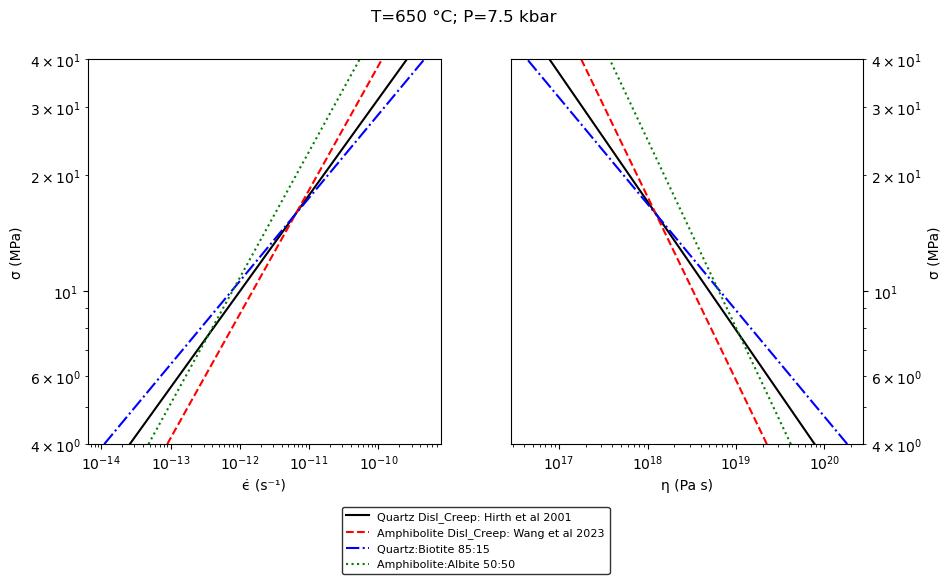

In [116]:
σ_ϵ_η_full([45,52], 650, P=750, σ_min=m.log10(4),σ_max=m.log10(40), mixing=True,\
           mixing_IDs=[45,13,52,0], model='MPGe', increment=[[85], [50]])

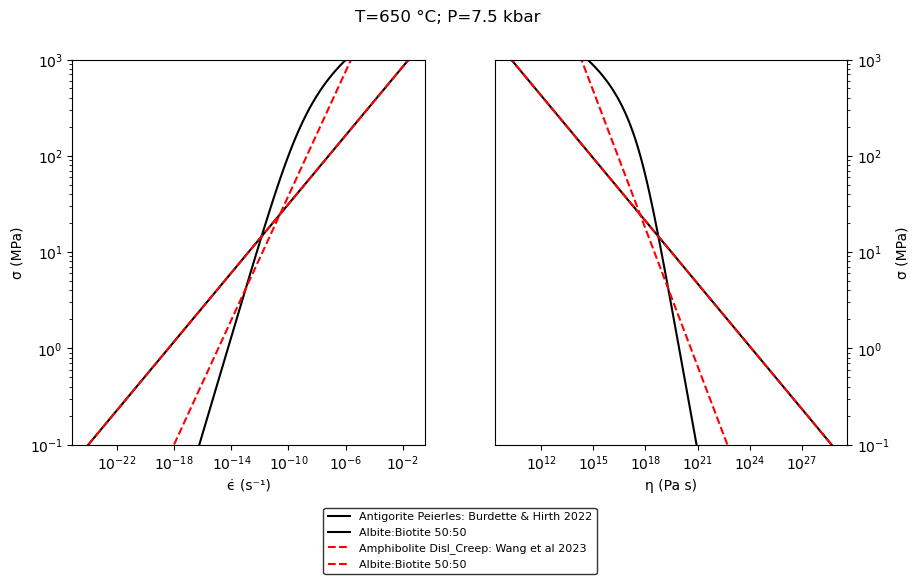

In [72]:
σ_ϵ_η_full([12,52], 650, P=750, σ_min=-1, σ_max=3, mixing=True, mixing_IDs=[0,13], model='MPGe', increment=[50])

In [96]:
dummy=[[90], [50]]

In [98]:
dummy[0][0]

90